# Exploring three time series classifiers from the sktime library towards short-term (~ one hour) predictions of SEP events.

## Author(s)
- Author1: Sumanth Rotti; Email: srotti@gsu.edu; ORCID: 0000-0003-1080-3424
- Author2: Berkay Aydin; Email: baydin2@gsu.edu; ORCID: 0000-0002-9799-9265
- Author3: Petrus C. Martens; Email: pmartens@gsu.edu; ORCID: 0000-0001-8078-6856
- Affiliation: Georgia State University

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from numpy import argmax, arange
from time import time
import glob
from typing import List, Union

In [2]:
#importing libraries
import sktime
import sktime.datatypes
from sktime.datatypes import check_is_mtype, check_raise

<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject


In [3]:
#importing libraries
from sklearn.ensemble import RandomForestClassifier
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.interval_based import SupervisedTimeSeriesForest
from sktime.classification.feature_based import SummaryClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.hybrid import HIVECOTEV2
from sktime.classification.kernel_based import RocketClassifier

In [4]:
#importing libraries
from sklearn import metrics
from sklearn.preprocessing import binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, roc_auc_score, roc_curve, DetCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import (brier_score_loss, log_loss, recall_score)

In [5]:
#importing plotting libraries
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn_evaluation import plot

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
plt.rcParams.update({'font.size': 13})

# Loading the data set

- We will use the 433 (244+189) samples in the GSEP data set and an additional 2,460 negative samples introducing a natural class imbalance between SEPs and non-SEPs

In [8]:
# Reading .csv files
extension = 'csv'
csv_filepath_list  = sorted([i for i in glob.glob(r'./data/*.{}'.format(extension))])
print(len(csv_filepath_list))

2893


In [9]:
# List of column headers to read from the csv files
features = ['p3_flux_ic','p5_flux_ic','p7_flux_ic','long']

In [10]:
# Read and convert each .csv file individually
csv_list = []
for csv_index, csv_path_i in enumerate(csv_filepath_list):
    #Considering 11 hr of observation minus 60 minutes before the SEP event onset
    csv_df_i = pd.read_csv(csv_path_i, sep=',', header=0, nrows = 660, usecols = features)
    #append sktime DataFrames to a list
    csv_list.append(csv_df_i)
len(csv_list)

2893

In [11]:
# Checking for sktime data format compatibility
check_is_mtype(csv_list, mtype="df-list", return_metadata=True)

(True,
 None,
 {'is_univariate': False,
  'is_equally_spaced': True,
  'is_equal_length': True,
  'is_empty': False,
  'has_nans': False,
  'is_one_series': False,
  'n_panels': 1,
  'is_one_panel': True,
  'n_instances': 2893,
  'n_features': 4,
  'feature_names': ['p3_flux_ic', 'p5_flux_ic', 'p7_flux_ic', 'long'],
  'mtype': 'df-list',
  'scitype': 'Panel'})

In [12]:
# Loading  the class label file 
tgt = pd.read_csv("labels.csv")

In [13]:
#renaming the label column to 'target'
tgt.rename(columns = {'Label':'target'}, inplace = True)

In [14]:
tgt.head(3)

,File,target
0,1986-01-15_05-54.csv,0
1,1986-01-15_19-57.csv,0
2,1986-01-16_15-16.csv,0


# Splitting the data set

In [15]:
# training set
X_train=csv_list[0:998]
y_train=tgt['target'][0:998]
# validation set
X_valid=csv_list[998:1972]
y_valid=tgt['target'][998:1972]
# test set
X_test=csv_list[1972:]
y_test=tgt['target'][1972:]

## Check the size of each data splits

In [16]:
print("Length of training set: ", len(X_train))
print("Length of validation set: ", len(X_valid))
print("Length of test set: ", len(X_test))

Length of training set:  998
Length of validation set:  974
Length of test set:  921


## Check the splitting size with respect to target

In [17]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T) 

[[  0 918]
 [  1  80]]


In [18]:
unique, counts = np.unique(y_valid, return_counts=True)
print(np.asarray((unique, counts)).T) 

[[  0 894]
 [  1  80]]


In [19]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T) 

[[  0 837]
 [  1  84]]


# Defining custom metrics

In [20]:
def tss(y, pred):
    '''
    Function to estimate true skill statistics (TSS) 
    
    Inputs:
    y - True labels
    pred - Predicted labels
    
    Returns:
    The TSS score for given input data
    '''
    TN, FP, FN, TP = confusion_matrix(y, pred).ravel()
    #
    x = TP * TN
    y = FP * FN
    A = TP + FN
    B = FN + TN
    C = TP + FP
    D = FP + TN
    #
    tot = TP + FP + FN + TN
    ref = ((A * C) / tot)
    #
    tss = round(((x - y) / (A * D)), 3)
    #
    return tss

In [21]:
def hss(y, pred):
    '''
    Function to estimate Heidke skill statistics (TSS) 
    
    Inputs:
    y - True labels
    pred - Predicted labels
    
    Returns:
    The HSS score for given input data
    '''
    TN, FP, FN, TP = confusion_matrix(y, pred).ravel()
    #
    x = TP * TN
    y = FP * FN
    A = TP + FN
    B = FN + TN
    C = TP + FP
    D = FP + TN
    #
    tot = TP + FP + FN + TN
    ref = ((A * C) / tot)
    #
    hss = round((2 * (x-y)/((A * B) + (C * D))), 3)
    #
    return hss

In [22]:
def gss(y, pred):
    '''
    Function to estimate Gilbert skill statistics (TSS) 
    
    Inputs:
    y - True labels
    pred - Predicted labels
    
    Returns:
    The GSS score for given input data
    '''
    TN, FP, FN, TP = confusion_matrix(y, pred).ravel()
    #
    x = TP * TN
    y = FP * FN
    A = TP + FN
    B = FN + TN
    C = TP + FP
    D = FP + TN
    #
    tot = TP + FP + FN + TN
    ref = ((A * C) / tot)
    #
    gss = round(((TP - ref) / (TP + FP + FN - ref)), 3)
    #
    return gss

# Defining a function to obtain the optimal classification threshold

In [23]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_proba, threshold):
    '''
    Function to convert probabilities to labels for a specific classification threshold
    
    Inputs:
    pos_proba - Predicted probability of input data point belonging to the respective class
    threshold - Threhsold defining the boundary to separate the target class labels
    
    Returns:
    Labels for the predicted probabilities 
    '''
    return (pos_proba >= threshold).astype('int')

In [24]:
# define thresholds as a numpy array
thresholds_cust = arange(0, 1, 0.01)

In [25]:
rand=3

# Summary Classifier

## Training set

In [26]:
ssc_train_run_start = time()
summ = ColumnEnsembleClassifier(
    estimators=[
        ("summ_0", SummaryClassifier(estimator=RandomForestClassifier(n_estimators=200), random_state=rand), ["p3_flux_ic"]),
        ("summ_1", SummaryClassifier(estimator=RandomForestClassifier(n_estimators=200), random_state=rand), ["p5_flux_ic"]),
        ("summ_2", SummaryClassifier(estimator=RandomForestClassifier(n_estimators=200), random_state=rand), ["p7_flux_ic"]),
        ("summ_3", SummaryClassifier(estimator=RandomForestClassifier(n_estimators=200), random_state=rand), ["long"])
     ]
)
summ.fit(X_train, y_train)
ssc_train_run_end = time()

In [27]:
# Get the model training run time (in seconds)
ssc_train_run_time = round((ssc_train_run_end - ssc_train_run_start))
print('Training time of the SSC model -- %f' % (ssc_train_run_time))

Training time of the SSC model -- 42.000000


## Validation set

In [28]:
# predict probabilities on the validation set
ssc_run_start = time()
probs_summ = summ.predict_proba(X_valid)[:,1]
ssc_run_end = time()

In [29]:
# calculate ROC curves
fpr_summ, tpr_summ, thresholds_summ = roc_curve(y_valid, probs_summ)
# get the best threshold using  Youden’s J statistic
J_summ = tpr_summ - fpr_summ
ix_summ = argmax(J_summ)
best_thre_summ = thresholds_summ[ix_summ]
print('Best Threshold = %f' % (best_thre_summ))

Best Threshold = 0.156460


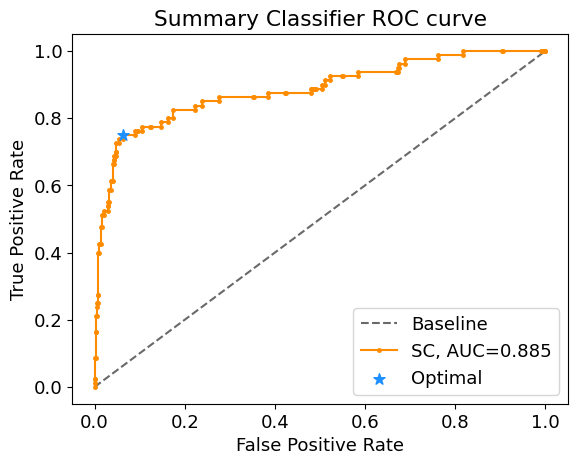

In [30]:
# plot the roc curve for the model
auc_summ = round(roc_auc_score(y_valid, probs_summ), 3)
pyplot.plot([0,1], [0,1], linestyle='--', color = 'dimgrey', label='Baseline')
pyplot.plot(fpr_summ, tpr_summ, marker='.', color = 'darkorange', markersize=5, label="SC, AUC="+str(auc_summ))
pyplot.scatter(fpr_summ[ix_summ], tpr_summ[ix_summ], marker='*', s=70, color='dodgerblue', label='Optimal', zorder=2)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# displaying the title
plt.title("Summary Classifier ROC curve")
# show the plot
pyplot.show()

In [31]:
# Get the model run time
ssc_run_time = round((ssc_run_end - ssc_run_start))
# evaluate scores for each threshold
f_score_summ = [f1_score(y_valid, to_labels(probs_summ, t), average='weighted') for t in thresholds_cust]
tss_score_summ = [tss(y_valid, to_labels(probs_summ, t)) for t in thresholds_cust]
hss_score_summ = [hss(y_valid, to_labels(probs_summ, t)) for t in thresholds_cust]
gss_score_summ = [gss(y_valid, to_labels(probs_summ, t)) for t in thresholds_cust]
mcc_score_summ = [matthews_corrcoef(y_valid, to_labels(probs_summ, t)) for t in thresholds_cust]
# get best threshold
f1_ix_summ = argmax(f_score_summ)
tss_ix_summ = argmax(tss_score_summ)
hss_ix_summ = argmax(hss_score_summ)
gss_ix_summ = argmax(gss_score_summ)
mcc_ix_summ = argmax(mcc_score_summ)
print('Prediction run time of SSC-- %f' % (ssc_run_time))

Prediction run time of SSC-- 38.000000


### Visualizing the variation in scores for different thresholds.

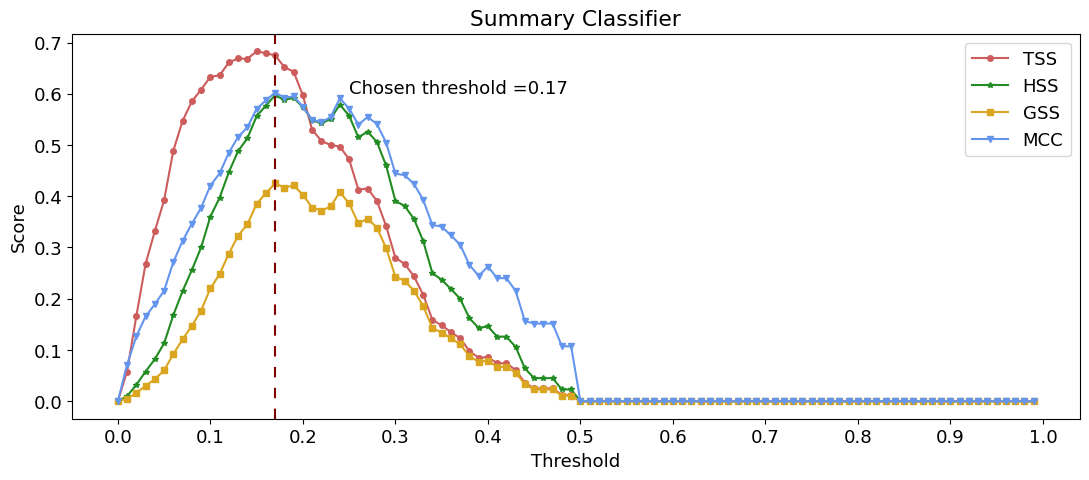

In [32]:
plt.figure(figsize=(13,5))
pyplot.plot(thresholds_cust, np.array(tss_score_summ), marker='o', markersize=4, color='indianred',  label='TSS')
pyplot.plot(thresholds_cust, np.array(hss_score_summ), marker='*', markersize=4, color='forestgreen', label='HSS')
pyplot.plot(thresholds_cust, np.array(gss_score_summ), marker='s', markersize=4, color='goldenrod', label='GSS')
pyplot.plot(thresholds_cust, np.array(mcc_score_summ), marker='v', markersize=4, color='cornflowerblue', label='MCC')
plt.axvline(x = thresholds_cust[hss_ix_summ], color="maroon", linestyle=(0, (5, 5)))
plt.text(0.25, 0.6, r'Chosen threshold ='+str(thresholds_cust[hss_ix_summ]))
plt.xticks(np.arange(0.0, 1.1, step=0.1))
# axis labels
pyplot.xlabel('Threshold')
pyplot.ylabel('Score')
pyplot.legend()
# displaying the title
plt.title("Summary Classifier")
# show the plot
pyplot.show()

In [33]:
#Choosing the best classification threshold of the SSC model
best_summ = thresholds_cust[hss_ix_summ]

In [34]:
# evaluate the best threshold
f1_scorex_summ = f1_score(y_valid, to_labels(probs_summ, best_summ), average='weighted')
tss_scorex_summ = tss(y_valid, to_labels(probs_summ, best_summ))
hss_scorex_summ = hss(y_valid, to_labels(probs_summ, best_summ))
gss_scorex_summ = gss(y_valid, to_labels(probs_summ, best_summ))
mcc_scorex_summ = matthews_corrcoef(y_valid, to_labels(probs_summ, best_summ))
print('Best Threshold = %.3f' %(best_summ))
print('Scores -- F1_Score: %.3f / TSS: %f / HSS: %f / GSS: %f / MCC: %f' % (f1_scorex_summ, tss_scorex_summ, hss_scorex_summ,
                                                                            gss_scorex_summ, mcc_scorex_summ))

Best Threshold = 0.170
Scores -- F1_Score: 0.935 / TSS: 0.675000 / HSS: 0.597000 / GSS: 0.425000 / MCC: 0.602385


### Validation set confusion matrix on the best threshold

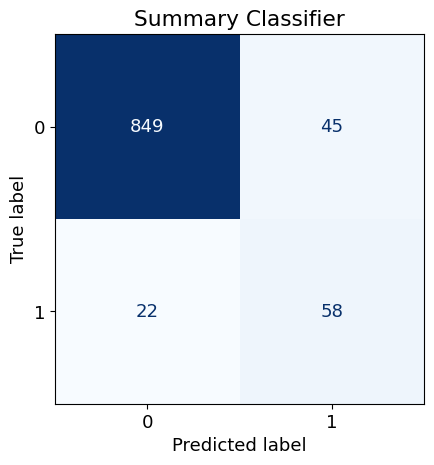

In [35]:
y_pred_class_summ = to_labels(probs_summ, best_summ)
color = 'white'
summ_matrix = ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_class_summ,
                                                     cmap=plt.cm.Blues, colorbar=False)
summ_matrix.ax_.set(title='Summary Classifier')
plt.show()

## Test set

In [36]:
# predict probabilities on the test set
probX_summ = summ.predict_proba(X_test)[:,1]

In [37]:
# evaluate on the best threshold
f1_test_summ = (f1_score(y_test, to_labels(probX_summ, best_summ), average='weighted'))
tss_test_summ = tss(y_test, to_labels(probX_summ, best_summ))
hss_test_summ = hss(y_test, to_labels(probX_summ, best_summ))
gss_test_summ = gss(y_test, to_labels(probX_summ, best_summ))
mcc_test_summ = matthews_corrcoef(y_test, to_labels(probX_summ, best_summ))
print('Test scores -- F1_Score: %.3f / TSS: %.3f / HSS: %.3f / GSS: %.3f / MCC: %.3f' % (f1_test_summ, tss_test_summ, 
                                                                          hss_test_summ, gss_test_summ,
                                                                          mcc_test_summ))

Test scores -- F1_Score: 0.935 / TSS: 0.720 / HSS: 0.632 / GSS: 0.462 / MCC: 0.639


### Test set confusion matrix on the best threshold

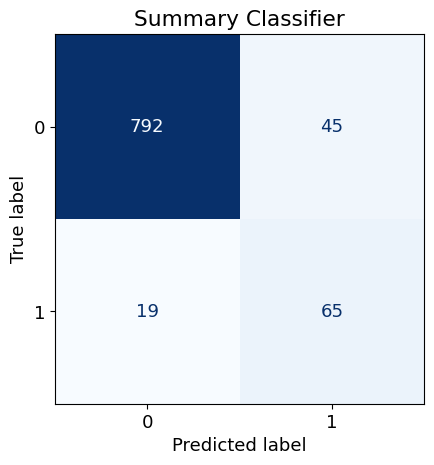

In [38]:
color = 'white'
y_pred_test_summ = to_labels(probX_summ, best_summ)
summ_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_summ,
                                                     cmap=plt.cm.Blues, colorbar=False)
summ_matrix.ax_.set(title='Summary Classifier')
plt.show()

# SupervisedTimeSeriesForest

## Training set

In [39]:
stsf_train_run_start = time()
stsf = ColumnEnsembleClassifier(
    estimators=[
        ("stsf_0", SupervisedTimeSeriesForest(n_estimators=200, random_state=rand), ["p3_flux_ic"]),
        ("stsf_1", SupervisedTimeSeriesForest(n_estimators=200, random_state=rand), ["p5_flux_ic"]),
        ("stsf_2", SupervisedTimeSeriesForest(n_estimators=200, random_state=rand), ["p7_flux_ic"]),
        ("stsf_3", SupervisedTimeSeriesForest(n_estimators=200, random_state=rand), ["long"])
     ]
)
stsf.fit(X_train, y_train)
stsf_train_run_end = time()

In [40]:
# Get the model training run time (in seconds)
stsf_train_run_time = round((stsf_train_run_end - stsf_train_run_start))
print('Training time of the STSF model -- %f' % (stsf_train_run_time))

Training time of the STSF model -- 676.000000


## Validation set

In [41]:
# predict probabilities on the validation set
stsf_run_start = time()
probs_stsf = stsf.predict_proba(X_valid)[:,1]
stsf_run_end = time()

In [42]:
# calculate ROC curves
fpr_stsf, tpr_stsf, thresholds_stsf = roc_curve(y_valid, probs_stsf)
# get the best threshold using  Youden’s J statistic
J_stsf = tpr_stsf - fpr_stsf
ix_stsf = argmax(J_stsf)
best_thre_stsf = thresholds_stsf[ix_stsf]
print('Best Threshold = %f' % (best_thre_stsf))

Best Threshold = 0.146250


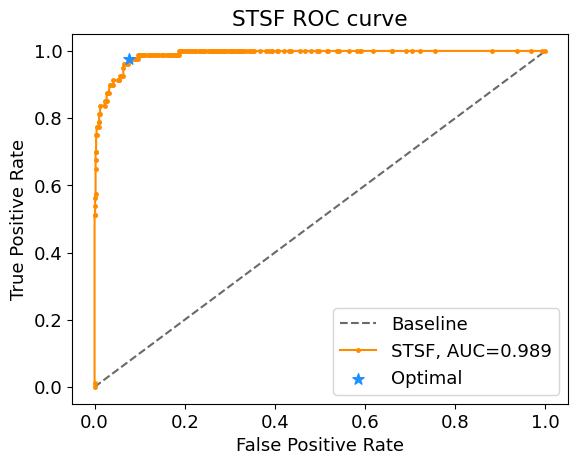

In [43]:
# plot the roc curve for the model
auc_stsf = round(roc_auc_score(y_valid, probs_stsf), 3)
pyplot.plot([0,1], [0,1], linestyle='--', color = 'dimgrey', label='Baseline')
pyplot.plot(fpr_stsf, tpr_stsf, marker='.', color = 'darkorange', markersize=5, label="STSF, AUC="+str(auc_stsf))
pyplot.scatter(fpr_stsf[ix_stsf], tpr_stsf[ix_stsf], marker='*', s=70, color='dodgerblue', label='Optimal', zorder=2)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# displaying the title
plt.title("STSF ROC curve")
# show the plot
pyplot.show()

In [44]:
# Get the model run time
stsf_run_time = round((stsf_run_end - stsf_run_start))
# evaluate scores for each threshold
f_score_stsf = [f1_score(y_valid, to_labels(probs_stsf, t), average='weighted') for t in thresholds_cust]
tss_score_stsf = [tss(y_valid, to_labels(probs_stsf, t)) for t in thresholds_cust]
hss_score_stsf = [hss(y_valid, to_labels(probs_stsf, t)) for t in thresholds_cust]
gss_score_stsf = [gss(y_valid, to_labels(probs_stsf, t)) for t in thresholds_cust]
mcc_score_stsf = [matthews_corrcoef(y_valid, to_labels(probs_stsf, t)) for t in thresholds_cust]
# get best threshold
f1_ix_stsf = argmax(f_score_stsf)
tss_ix_stsf = argmax(tss_score_stsf)
hss_ix_stsf = argmax(hss_score_stsf)
gss_ix_stsf = argmax(gss_score_stsf)
mcc_ix_stsf = argmax(mcc_score_stsf)
print('Prediction run time of STSF -- %f' % (stsf_run_time))

Prediction run time of STSF -- 133.000000


### Visualizing the variation in scores for different thresholds.

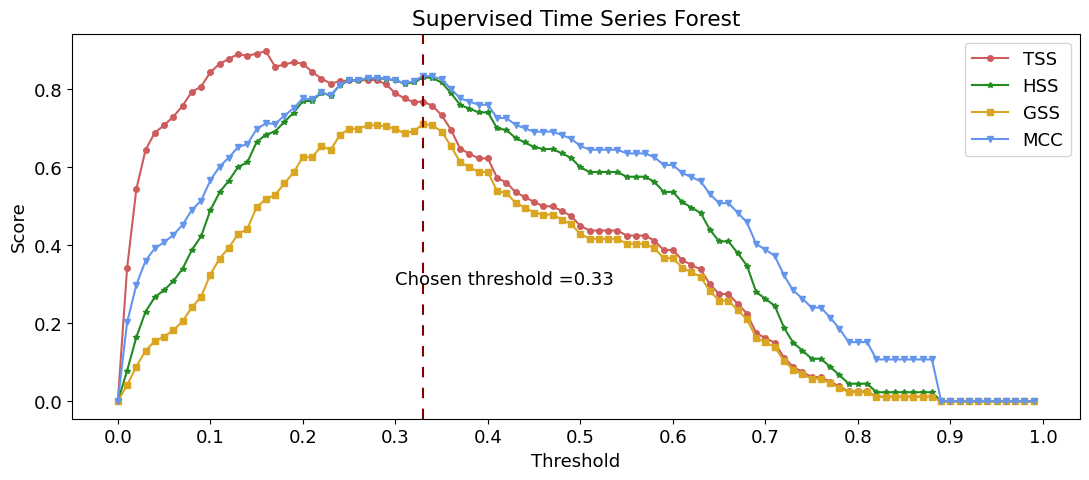

In [45]:
plt.figure(figsize=(13,5))
pyplot.plot(thresholds_cust, np.array(tss_score_stsf), marker='o', markersize=4, color='indianred',  label='TSS')
pyplot.plot(thresholds_cust, np.array(hss_score_stsf), marker='*', markersize=4, color='forestgreen', label='HSS')
pyplot.plot(thresholds_cust, np.array(gss_score_stsf), marker='s', markersize=4, color='goldenrod', label='GSS')
pyplot.plot(thresholds_cust, np.array(mcc_score_stsf), marker='v', markersize=4, color='cornflowerblue', label='MCC')
plt.axvline(x = thresholds_cust[hss_ix_stsf], color="maroon", linestyle=(0, (5, 5)))
plt.text(0.3, 0.3, r'Chosen threshold ='+str(thresholds_cust[f1_ix_stsf]))
plt.xticks(np.arange(0.0, 1.1, step=0.1))
# axis labels
pyplot.xlabel('Threshold')
pyplot.ylabel('Score')
pyplot.legend()
# displaying the title
plt.title("Supervised Time Series Forest")
# show the plot
pyplot.show()

In [46]:
#Choosing the best classification threshold of the STSF model
best_stsf = thresholds_cust[hss_ix_stsf]

In [47]:
# evaluate the best threshold
f1_scorex_stsf = f1_score(y_valid, to_labels(probs_stsf, best_stsf), average='weighted')
tss_scorex_stsf = tss(y_valid, to_labels(probs_stsf, best_stsf))
hss_scorex_stsf = hss(y_valid, to_labels(probs_stsf, best_stsf))
gss_scorex_stsf = gss(y_valid, to_labels(probs_stsf, best_stsf))
mcc_scorex_stsf = matthews_corrcoef(y_valid, to_labels(probs_stsf, best_stsf))
print('Best Threshold = %.3f' %(best_stsf))
print('Scores -- F1_Score: %.3f / TSS: %f / HSS: %f / GSS: %f / MCC: %f' % (f1_scorex_stsf, tss_scorex_stsf, hss_scorex_stsf,
                                                                            gss_scorex_stsf, mcc_scorex_stsf))

Best Threshold = 0.330
Scores -- F1_Score: 0.975 / TSS: 0.769000 / HSS: 0.831000 / GSS: 0.711000 / MCC: 0.834697


### Validation set confusion matrix on the best threshold

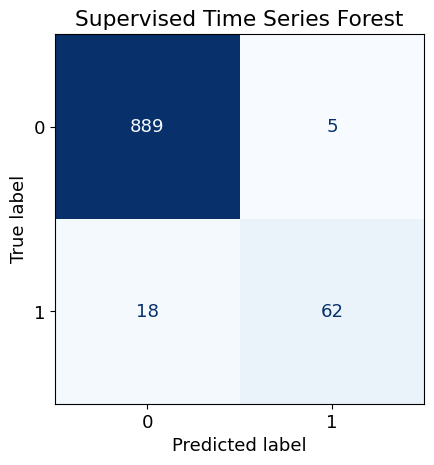

In [48]:
y_pred_class_stsf = to_labels(probs_stsf, best_stsf)
color = 'white'
stsf_matrix = ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_class_stsf,
                                                     cmap=plt.cm.Blues, colorbar=False)
stsf_matrix.ax_.set(title='Supervised Time Series Forest')
plt.show()

## Test set

In [49]:
# predict probabilities on the test set
probX_stsf = stsf.predict_proba(X_test)[:,1]

In [50]:
# evaluate on the best threshold
f1_test_stsf = (f1_score(y_test, to_labels(probX_stsf, best_stsf), average='weighted'))
tss_test_stsf = tss(y_test, to_labels(probX_stsf, best_stsf))
hss_test_stsf = hss(y_test, to_labels(probX_stsf, best_stsf))
gss_test_stsf = gss(y_test, to_labels(probX_stsf, best_stsf))
mcc_test_stsf = matthews_corrcoef(y_test, to_labels(probX_stsf, best_stsf))
print('Test scores -- F1_Score: %.3f / TSS: %.3f / HSS: %.3f / GSS: %.3f / MCC: %.3f' % (f1_test_stsf, tss_test_stsf, 
                                                                          hss_test_stsf, gss_test_stsf,
                                                                          mcc_test_stsf))

Test scores -- F1_Score: 0.980 / TSS: 0.850 / HSS: 0.878 / GSS: 0.783 / MCC: 0.879


### Test set confusion matrix on the best threshold

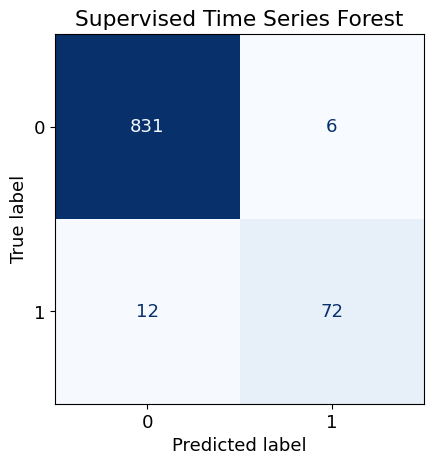

In [51]:
color = 'white'
y_pred_test_stsf = to_labels(probX_stsf, best_stsf)
stsf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_stsf,
                                                     cmap=plt.cm.Blues, colorbar=False)
stsf_matrix.ax_.set(title='Supervised Time Series Forest')
plt.show()

# KNeighborsTimeSeriesClassifier

## Training set

In [52]:
knnts = KNeighborsTimeSeriesClassifier(n_neighbors=1, weights= 'distance', distance="dtw")
knnts.fit(X_train, y_train)

KNeighborsTimeSeriesClassifier(weights='distance')

## Validation set

In [53]:
# predict probabilities on the validation set
knn_run_start = time()
probs_knnts = knnts.predict_proba(X_valid)[:,1]
knn_run_end = time()

In [54]:
# Get the model run time
knn_run_time = round((knn_run_end - knn_run_start))
# evaluate scores for each threshold
f_score_knnts = [f1_score(y_valid, to_labels(probs_knnts, t), average='weighted') for t in thresholds_cust]
tss_score_knnts = [tss(y_valid, to_labels(probs_knnts, t)) for t in thresholds_cust]
hss_score_knnts = [hss(y_valid, to_labels(probs_knnts, t)) for t in thresholds_cust]
gss_score_knnts = [gss(y_valid, to_labels(probs_knnts, t)) for t in thresholds_cust]
mcc_score_knnts = [matthews_corrcoef(y_valid, to_labels(probs_knnts, t)) for t in thresholds_cust]
# get best threshold
f1_ix_knnts = argmax(f_score_knnts)
tss_ix_knnts = argmax(tss_score_knnts)
hss_ix_knnts = argmax(hss_score_knnts)
gss_ix_knnts = argmax(gss_score_knnts)
mcc_ix_knnts = argmax(mcc_score_knnts)
print('Prediction run time of KNN -- %f' % (knn_run_time))

Prediction run time of KNN -- 3691.000000


In [55]:
#Choosing the best classification threshold of the KNN model
best_knnts = thresholds_cust[hss_ix_knnts]

In [56]:
# evaluate the best threshold
f1_scorex_knnts = f1_score(y_valid, to_labels(probs_knnts, best_knnts), average='weighted')
tss_scorex_knnts = tss(y_valid, to_labels(probs_knnts, best_knnts))
hss_scorex_knnts = hss(y_valid, to_labels(probs_knnts, best_knnts))
gss_scorex_knnts = gss(y_valid, to_labels(probs_knnts, best_knnts))
mcc_scorex_knnts = matthews_corrcoef(y_valid, to_labels(probs_knnts, best_knnts))
print('Best Threshold = %.3f' %(best_knnts))
print('Scores -- F1_Score: %.3f / TSS: %f / HSS: %f / GSS: %f / MCC: %f' % (f1_scorex_knnts, tss_scorex_knnts, hss_scorex_knnts,
                                                                            gss_scorex_knnts, mcc_scorex_knnts))

Best Threshold = 0.010
Scores -- F1_Score: 0.931 / TSS: 0.505000 / HSS: 0.529000 / GSS: 0.360000 / MCC: 0.530015


### Validation set confusion matrix on the best threshold

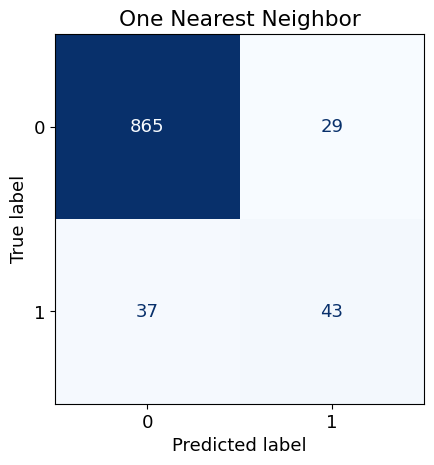

In [57]:
y_pred_class_knnts = to_labels(probs_knnts, best_knnts)
color = 'white'
knnts_matrix = ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_class_knnts,
                                                     cmap=plt.cm.Blues, colorbar=False)
knnts_matrix.ax_.set(title='One Nearest Neighbor')
plt.show()

## Test set

In [58]:
# predict probabilities on the test set
probX_knnts = knnts.predict_proba(X_test)[:,1]

In [59]:
# evaluate on the best threshold
f1_test_knnts = (f1_score(y_test, to_labels(probX_knnts, best_knnts), average='weighted'))
tss_test_knnts = tss(y_test, to_labels(probX_knnts, best_knnts))
hss_test_knnts = hss(y_test, to_labels(probX_knnts, best_knnts))
gss_test_knnts = gss(y_test, to_labels(probX_knnts, best_knnts))
mcc_test_knnts = matthews_corrcoef(y_test, to_labels(probX_knnts, best_knnts))
print('Test scores -- F1_Score: %.3f / TSS: %.3f / HSS: %.3f / GSS: %.3f / MCC: %.3f' % (f1_test_knnts, tss_test_knnts, 
                                                                          hss_test_knnts, gss_test_knnts,
                                                                          mcc_test_knnts))

Test scores -- F1_Score: 0.946 / TSS: 0.632 / HSS: 0.668 / GSS: 0.501 / MCC: 0.669


### Test set confusion matrix on the best threshold

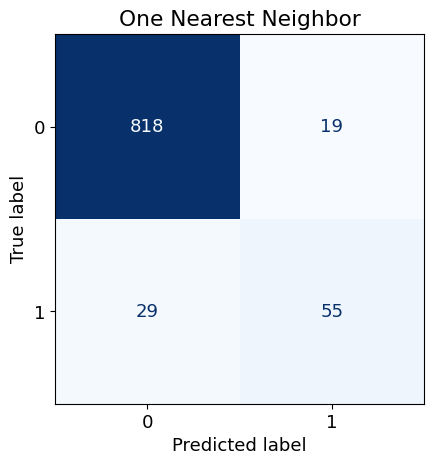

In [60]:
color = 'white'
y_pred_test_knnts = to_labels(probX_knnts, best_knnts)
knnts_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_knnts,
                                                     cmap=plt.cm.Blues, colorbar=False)
knnts_matrix.ax_.set(title='One Nearest Neighbor')
plt.show()